In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import gymnasium as gym
import time
from tqdm import tqdm
import winsound
from torch.distributions import Normal, Categorical
from copy import deepcopy

from FlatOrientation import *
from PPO import *

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

from IPython.display import display, clear_output

sns.set_theme()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

%load_ext autoreload
%autoreload 2

## Ориентация КА, PPO

## I. Привидение в точку за 1 секунду

### Обучение

In [6]:
env = FlatOrientation(dt=1e-1, integration='Euler')

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [9]:
agent = PPO(
    state_dim=3,
    action_dim=1, 
    max_action=25, 
    observable_states=[0, 1, 2],
    gamma=1
)

# agent.pi_model = torch.load('models/flat_orientation_pi_140.pth')
# agent.v_model = torch.load('models/flat_orientation_v_140.pth')

In [11]:
train_ppo(
    env, 
    agent, 
    episode_n=10, 
    trajectory_n=100, 
    advantage='default',
)

0: mean reward = -13441.820350955057
1: mean reward = -13338.56813049922
2: mean reward = -12109.72982188858
3: mean reward = -11924.000024537694
4: mean reward = -9798.356228769717
5: mean reward = -12362.602048773508
6: mean reward = -9584.856410574801
7: mean reward = -8850.698342033553
8: mean reward = -9221.28177919137
9: mean reward = -8063.8862622911365


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


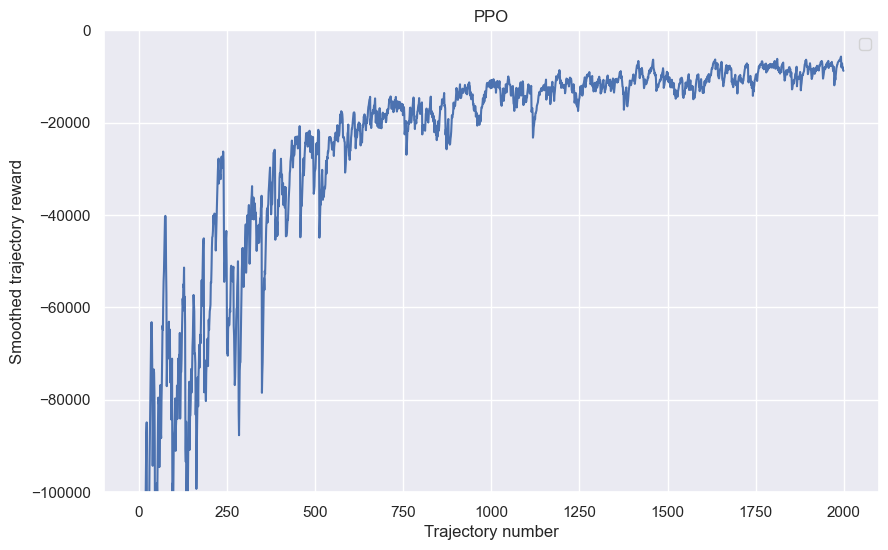

In [14]:
plot_history(agent.history, ylim=[-10**5, 0])

### Валидация

In [15]:
validation_env = FlatOrientation(dt=1e-3)

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [16]:
class AnaliticalAgent(PPO):
    def __init__(self):
        self.discrete_action_space = False
        self.max_action = 1
        self.observable_states = [0, 1, 2]

    def get_action(self, state, prediction=False):
        return [6 * np.pi - 12 * np.pi * state[0]]

In [17]:
validation(validation_env, agent, validation_n=10, prediction=True)

-4043.912347398314

### Управление:

In [18]:
def get_reward(env, agent):
    traj = agent.get_trajectory(env, prediction=True, initial_state=np.array([0, 0, 0]))
    return sum(traj['rewards'])

In [19]:
get_reward(env, agent)

-4222.901856241043

In [20]:
get_reward(env, AnaliticalAgent())

-11860.737871382731

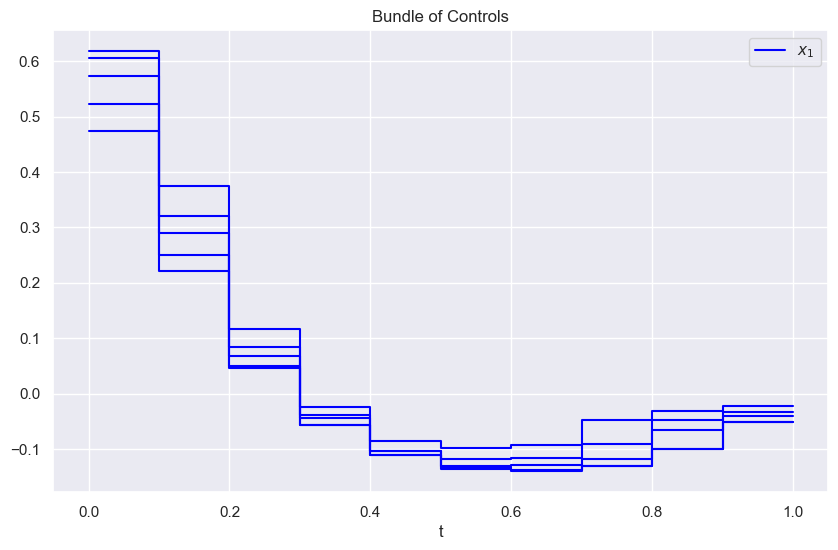

In [21]:
plot_u(env, agent, n=5)

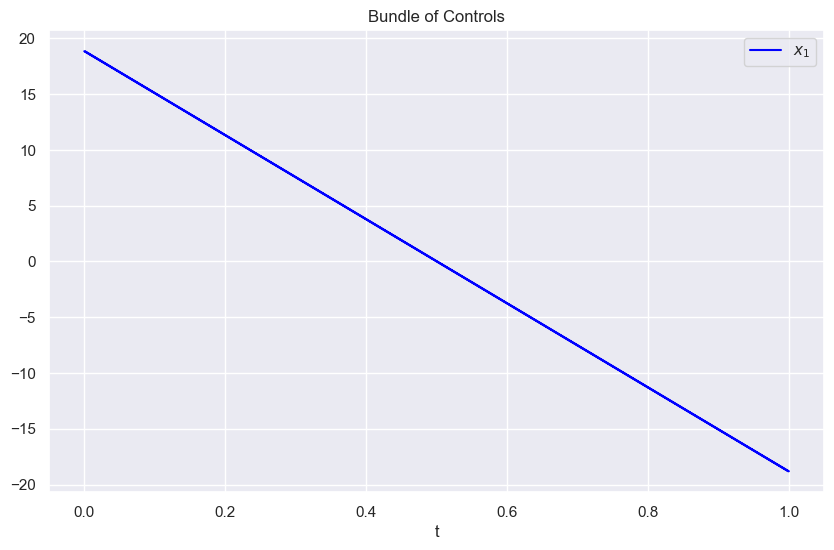

In [22]:
plot_u(validation_env, AnaliticalAgent())

0.009421636368116992 0.01884955592152448


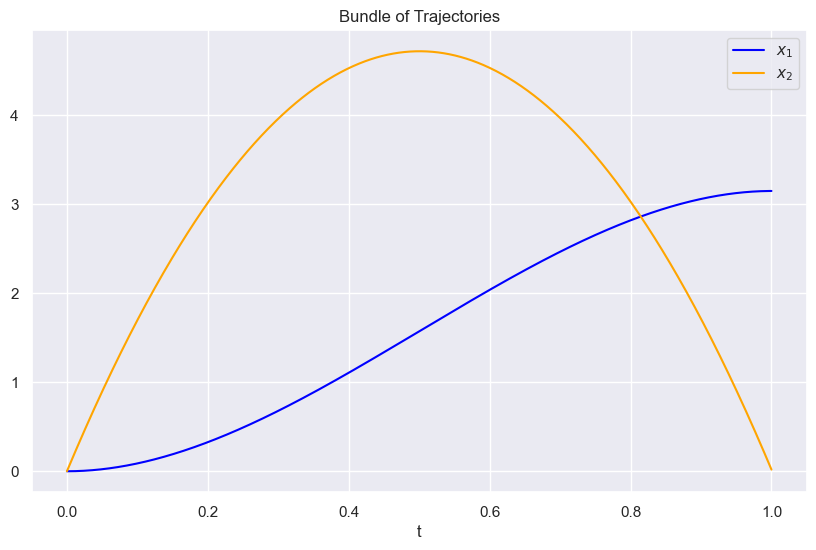

In [23]:
plot_sheaf(validation_env, AnaliticalAgent(), initial_state=[0, 0, 0])

-1.9262060277544426 0.7162185679543743


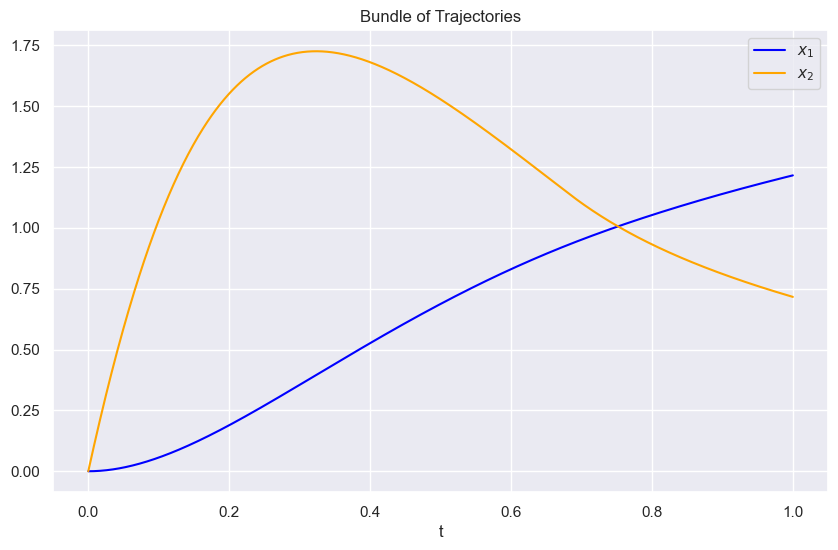

In [24]:
plot_sheaf(validation_env, agent, initial_state=np.array([0, 0, 0]))

-2.046524823961377 0.8503906911423171
-1.7999639645590406 0.5956745616057022
-2.009092437116795 0.8095769712653078
-1.817507493545215 0.6118426457297151
-1.943271523319354 0.7342257014909334


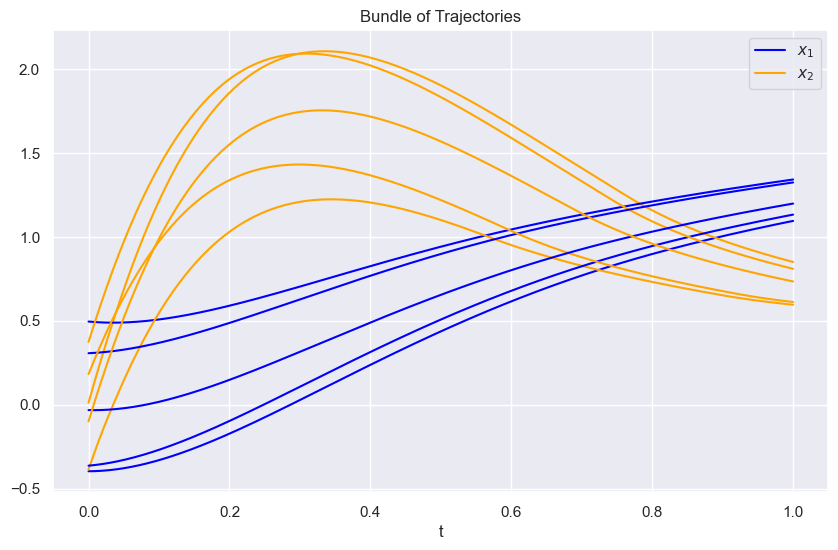

In [25]:
plot_sheaf(validation_env, agent, n=5)

In [174]:
# torch.save(agent.pi_model, 'models/flat_orientation_pi_135.pth')
# torch.save(agent.v_model, 'models/flat_orientation_v_135.pth')

### Testing

In [115]:
dt = 1e-4
euler_env = FlatOrientation(dt=dt, integration='Euler')
rk45_env = FlatOrientation(dt=dt, integration='RK45')

In [116]:
get_reward(euler_env, AnaliticalAgent()), get_reward(rk45_env, AnaliticalAgent())

(-118.43969626688481, -118.43969644452312)

0.0009423521327827089 0.0018849555936547922


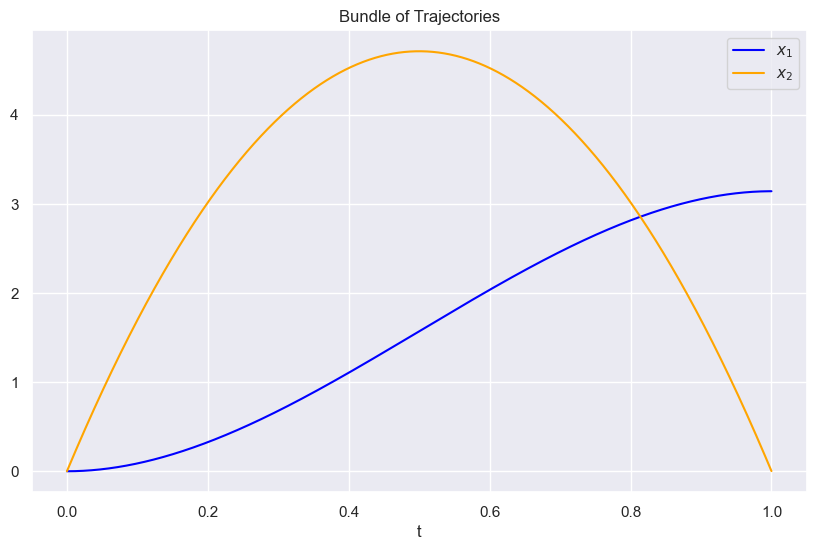

In [117]:
plot_sheaf(euler_env, AnaliticalAgent(), initial_state=[0, 0, 0])

0.0009424463801539495 0.0018849555939234805


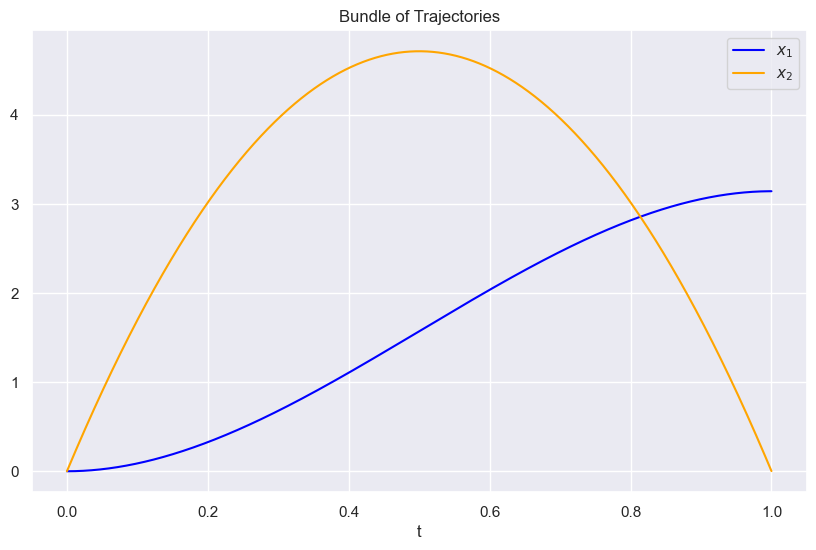

In [118]:
plot_sheaf(rk45_env, AnaliticalAgent(), initial_state=[0, 0, 0])

## II. Стабилизация на отрезке времени 3 секунды.

### Обучение

In [20]:
env = FlatOrientation(
    dt=1e-1, 
    t_end=3,
    R1=1,
    R2=0.1,
    R3=0.001,
    reward_function=stability_reward, 
    integration='Euler'
)

In [21]:
agent = PPO(
    state_dim=2,
    action_dim=1, 
    max_action=25, 
    observable_states=[1, 2],
    gamma=1
)

# agent.pi_model = torch.load('models/flat_orientation_pi_140.pth')
# agent.v_model = torch.load('models/flat_orientation_v_140.pth')

In [22]:
train_ppo(
    env, 
    agent, 
    episode_n=50, 
    trajectory_n=500, 
    advantage='default',
)

0: mean reward = -5538.052779755937
1: mean reward = -2047.804314223692
2: mean reward = -662.1483424375572
3: mean reward = -216.91987839285912
4: mean reward = -131.87053066520707
5: mean reward = -105.14232549913605
6: mean reward = -82.01138709115295
7: mean reward = -69.98791369023009
8: mean reward = -63.194940649414605
9: mean reward = -58.40553532429627
10: mean reward = -52.32519591832332
11: mean reward = -49.4759319220822
12: mean reward = -49.26871939209628
13: mean reward = -48.992259339183185
14: mean reward = -48.87422285432772
15: mean reward = -47.692169153116566
16: mean reward = -47.31120966073671
17: mean reward = -47.18085681007459
18: mean reward = -47.75179053344547
19: mean reward = -48.26032206232565
20: mean reward = -48.23047167542431
21: mean reward = -48.039108834179785
22: mean reward = -48.60281359813524
23: mean reward = -47.41404762654289
24: mean reward = -47.455135303302754
25: mean reward = -47.520928659069014
26: mean reward = -48.06248572940465
27:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


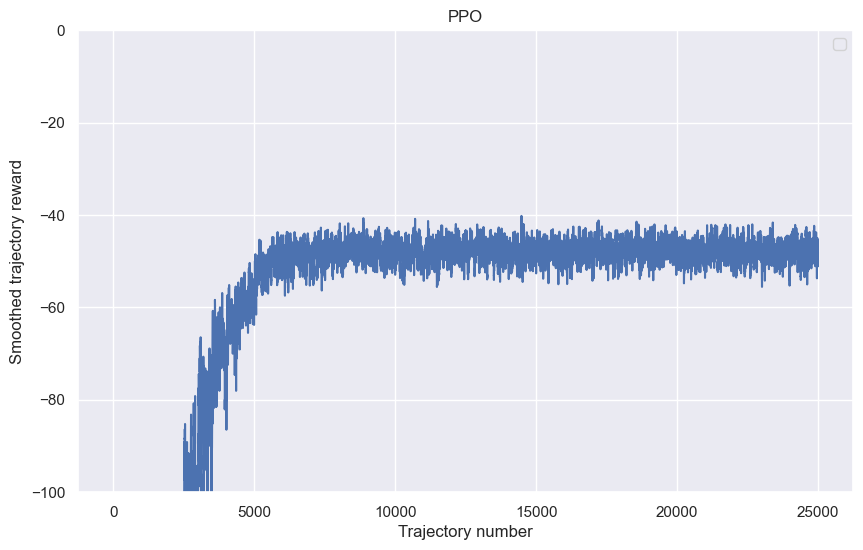

In [24]:
plot_history(agent.history, ylim=[-100, 0])

### Валидация

In [48]:
validation_env = FlatOrientation(
    dt=1e-1, 
    t_end=5,
    R1=1,
    R2=0.1,
    R3=0.001,
    reward_function=stability_reward,
    integration='Euler'
)

In [51]:
validation(validation_env, agent, validation_n=10, prediction=True)

-44.41134503689123

### Управление:

In [54]:
def get_reward(env, agent):
    traj = agent.get_trajectory(env, prediction=True, initial_state=np.array([0, 0, 0]))
    return sum(traj['rewards'])

In [56]:
get_reward(validation_env, agent)

-42.76117923821434

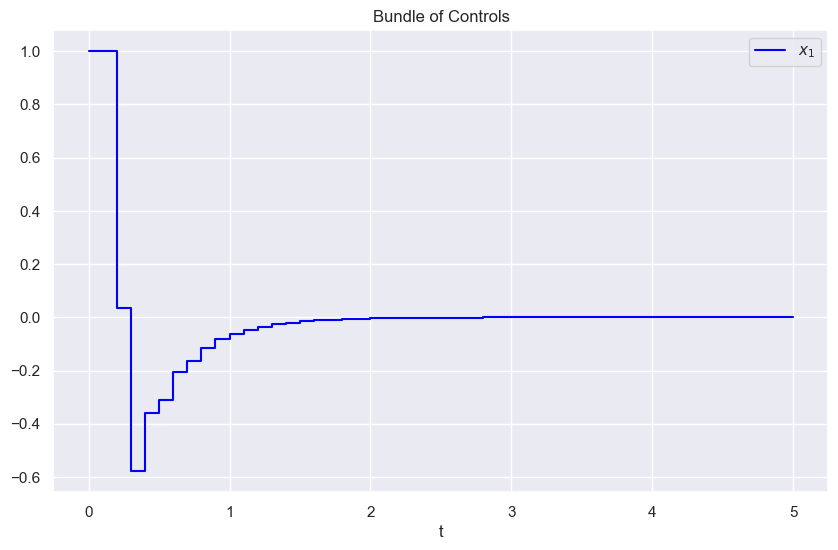

In [58]:
plot_u(validation_env, agent)

-0.008657334633642488 7.193256169883873e-06


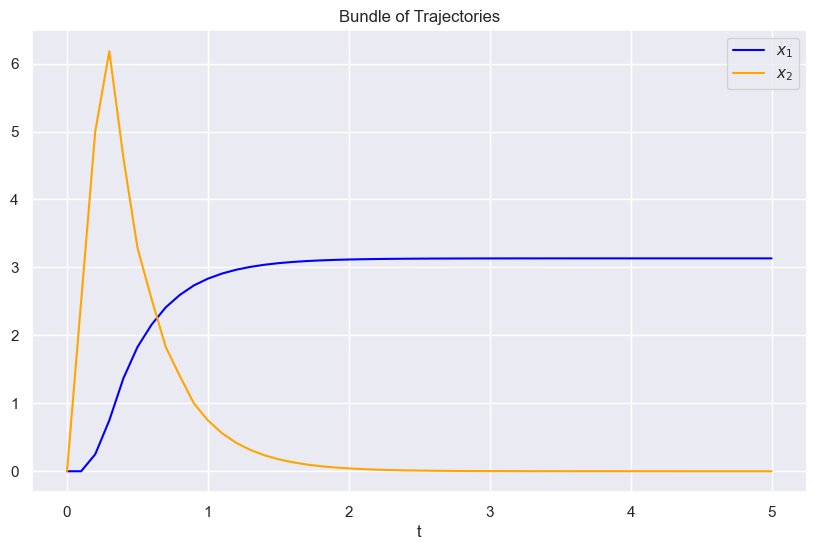

In [60]:
plot_sheaf(validation_env, agent, initial_state=np.array([0, 0, 0]))

In [61]:
# torch.save(agent.pi_model, 'models/flat_orientation_2_pi_40.pth')
# torch.save(agent.v_model, 'models/flat_orientation_2_v_40.pth')

## III. Pendulum testing

In [109]:
import gymnasium

In [110]:
env_pendulum = gymnasium.make('Pendulum-v1')

In [111]:
agent_pendulum = PPO(
    state_dim=3,
    action_dim=1, 
    max_action=2,
    observable_states=[0, 1, 2],
    gamma=0.9,
)

In [ ]:
train_ppo(
    env_pendulum, 
    agent_pendulum, 
    episode_n=25, 
    trajectory_n=20, 
    advantage='default',
)